<ipython-input-3-6b7f03827059>:46: RuntimeWarning: invalid value encountered in scalar divide
  relative_velocity = np.dot(target.velocity, target.position - radar_position) / distance
<ipython-input-3-6b7f03827059>:50: RuntimeWarning: divide by zero encountered in scalar divide
  signal_strength = target.rcs / (distance ** 2)


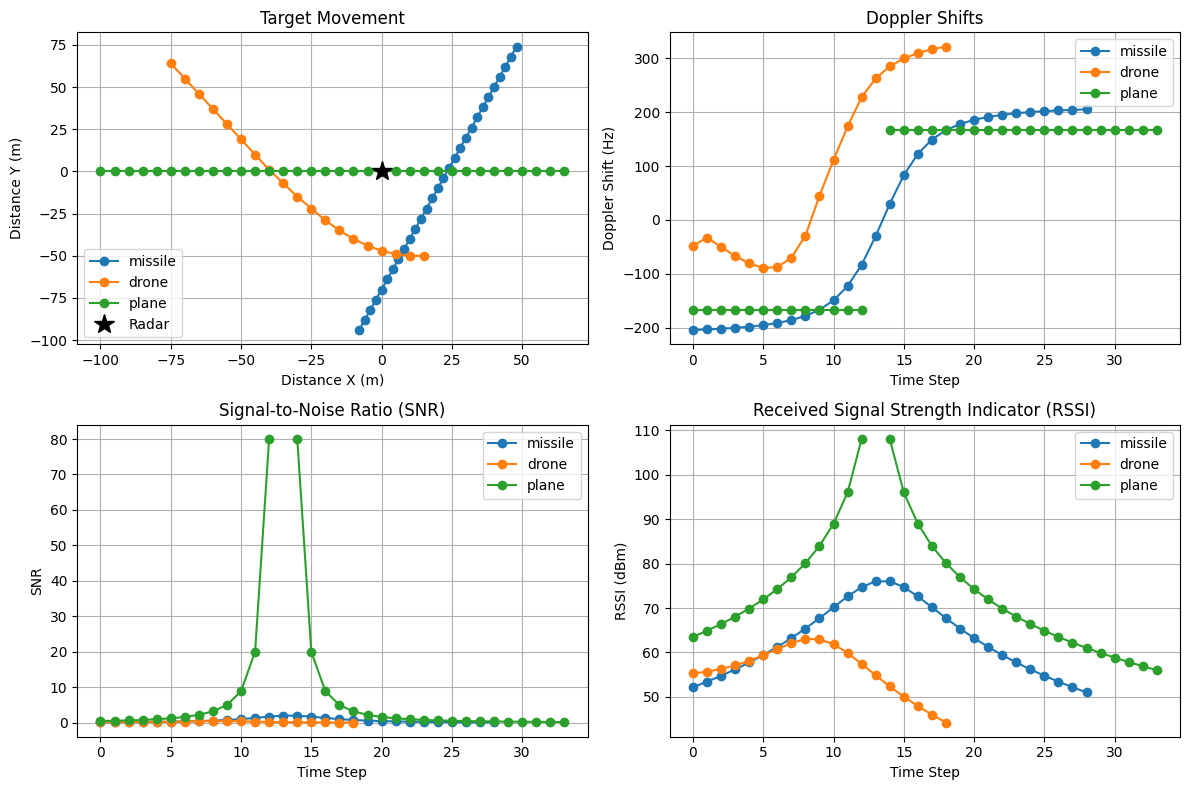

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class Target:
    def __init__(self, position, velocity, rcs):
        self.position = np.array(position)
        self.velocity = np.array(velocity)
        self.rcs = rcs  # Radar Cross Section

# Radar specifications
radar_position = np.array([0, 0])
radar_range = 100  # Radar range
radar_frequency = 10e9  # 10 GHz, example radar frequency
c = 3e8  # Speed of light in m/s

# Targets - Initial positions and velocities adjusted to ensure they enter the radar range.
missile = Target([50, 80], [-2, -6], rcs=1.0)  # Will move through the radar range
drone = Target([20, -50], [-5, 0], rcs=0.5)    # Will move towards the radar
plane = Target([70, 0], [-5, 0], rcs=2.0)      # Will move towards the radar

targets = [missile, drone, plane]

# Simulation parameters
time_steps = 50
dt = 1  # Time step duration

positions = {t: [] for t in ['missile', 'drone', 'plane']}
doppler_shifts = {t: [] for t in ['missile', 'drone', 'plane']}
snr_values = {t: [] for t in ['missile', 'drone', 'plane']}
rssi_values = {t: [] for t in ['missile', 'drone', 'plane']}

loop_frequency = 0.1  # Frequency of the loop

for step in range(time_steps):
    # Modulate the drone's vertical velocity to create a loop
    drone.velocity[1] = 10 * np.sin(loop_frequency * step)

    for t, target in zip(positions.keys(), targets):
        # Update target position
        target.position += target.velocity * dt

        # Calculate distance to radar
        distance = np.linalg.norm(target.position - radar_position)

        # Calculate Doppler shift
        relative_velocity = np.dot(target.velocity, target.position - radar_position) / distance
        doppler_shift = radar_frequency * (relative_velocity / c)

        # Simulate Radar Cross Section impact and calculate SNR
        signal_strength = target.rcs / (distance ** 2)
        noise = 1e-3  # Assume constant noise level
        snr = signal_strength / noise

        # Calculate RSSI
        rssi = (target.rcs * signal_strength * radar_frequency) / (distance ** 2)
        rssi_dBm = 10 * np.log10(rssi / 1e-3)  # Convert to dBm

        # Record data if target is within radar range
        if distance <= radar_range:
            positions[t].append(target.position.tolist())
            doppler_shifts[t].append(doppler_shift)
            snr_values[t].append(snr)
            rssi_values[t].append(rssi_dBm)
        else:
            positions[t].append([np.nan, np.nan])
            doppler_shifts[t].append(np.nan)
            snr_values[t].append(np.nan)
            rssi_values[t].append(np.nan)

# Visualization of positions and additional parameters like RSSI
plt.figure(figsize=(12, 8))

# Plotting positions
plt.subplot(2, 2, 1)
for t, history in positions.items():
    x, y = zip(*history)
    plt.plot(x, y, 'o-', label=t)
plt.plot(radar_position[0], radar_position[1], 'k*', label='Radar', markersize=15)
plt.legend()
plt.title('Target Movement')
plt.xlabel('Distance X (m)')
plt.ylabel('Distance Y (m)')
plt.grid(True)

# Plotting Doppler shifts
plt.subplot(2, 2, 2)
for t, shifts in doppler_shifts.items():
    plt.plot(shifts, 'o-', label=t)
plt.title('Doppler Shifts')
plt.xlabel('Time Step')
plt.ylabel('Doppler Shift (Hz)')
plt.legend()
plt.grid(True)

# Plotting SNR values
plt.subplot(2, 2, 3)
for t, snrs in snr_values.items():
    plt.plot(snrs, 'o-', label=t)
plt.title('Signal-to-Noise Ratio (SNR)')
plt.xlabel('Time Step')
plt.ylabel('SNR')
plt.legend()
plt.grid(True)

# Plotting RSSI values
plt.subplot(2, 2, 4)
for t, rssis in rssi_values.items():
    plt.plot(rssis, 'o-', label=t)
plt.title('Received Signal Strength Indicator (RSSI)')
plt.xlabel('Time Step')
plt.ylabel('RSSI (dBm)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()